## Gradient Boosting from Scratch

In this Jupyter Notebook I will explain about Gradient Boosting and I will show the implementation from scratch. Indeed, gradient boosting, is often used, maybe even with advanced implementations such as light gbm, xgboost and catboost, in many forecasting and classification projects. It is sometimes mistakenly used as a black box. I would like to show in this notebook a theoretical and practical explanation of the algorithm and model.



First gradient boosting idea, is to combine weak learners (we will use for example, regression threes: https://www.youtube.com/watch?v=g9c66TUylZ4) into an unique strong learner.



The general idea of the algorithm is to be able to minimise a differentiable loss  which as we shall see will be different depending on the objective. In general, depending on the objective, we will use:

$$L_{regression}(\hat{y},y)=\frac{1}{2}\sum_{i=1}^{n}{(\hat{y}_i-y_i^{m})^2}$$
$$L_{classification}(\hat{y},y)=\sum_{i=1}^{n}{\hat{y}_i \log(y_i^m)+(1-\hat{y}_i) \log(1-y_i^m)}$$

Where $y_i^m$ is (with a little notation abuse) the predicted value at $m$ iteration and $\hat{y}$ the observed value.
Note that they are very similar to MSE and Cross Entropy Function (used respectively for Linear and Logistic Regression).

In the next lines I will show you basic idea of this algorithm. 

$\texttt{Input}$:
- a training set  ${(X_{i},y_i)}_{i=1}^{n}$  where $X \in \mathbb{R}^{n \times N}$ is the matrix created with the $N$ feature we will use for our task (NOTE: $X_i$ indicates the i-th row of $X$);
- a differentiable loss $L(\hat{y},y)$;
- an iteration number $M$ (the number of weak learner we are going to create).

$\texttt{Algorithm}$:

For $m=0:M$

- $\text{if}$ $m=0$: initialize $F^0(X)=\arg \min_{\gamma}  L(\hat{y}_i,\gamma)$
- Compute pseudo residuals:
$$ r_i^m=-\Big [ \frac{\partial L(\hat{y}_i,F(X_{i}))}{\partial F(X_{i})} \Big ]_{F(X)=F_{m-1}(X)}\,\, \text{ where } i \in [1,n].$$
- Fit a weak learner $h^m(X)$ (usually, a regression tree) on the dataset
$$\{(X_{i},r_i^m)\}_{i=1}^{n}$$
with a terminal region $R_{j}^m$ with $j=1,... J^m$
- $\forall j \in [1,J^m]$ (where, I remember $.^m$ indicates the m-th iteration) compute
$$ \gamma_j^m= \arg \min_{\gamma} \sum_{X_i \in R_j^m}L(\hat{y}_i,F^{m-1}(X_i)+\gamma) $$
- Update the model:
$$F^m(X)=F^{m-1}(X)+ \mu \sum_{j=1}^{J^m} \gamma_j^m \mathbb{1}(X \in R_j^m)$$

where $\mathbb{1}$ function is defined as:
$$ \mathbb{1}(X \in R_j^m)_i=
\begin{cases}
1\,\, \text{if}\,\, X_i \in R_j^m,\\
0 \,\, \text{if}\,\, X_i \not \in R_j^m,
\end{cases}\,\,\, i \in [0,n].
$$
NOTE: $\mu \in (0,1]$ is just a regularization parameter, to avoid overfitting.

We will now look at the two well separated cases of regression and classification.

Although the algorithm shown earlier does indeed seem very complex, it is not as absurd as one might think. As always, just do the maths :). I remember that, for this tas, we will want to minimize loss:
$$ L(\hat{y},y)=\frac{1}{2} \sum_{i=1}^n (\hat{y}_i-y_i)^2$$. As first step we want then to compute
$$F^0(X)=\arg \min_{\gamma} L(\hat{y},\gamma).$$
Since it is a smooth, convex function, it is possible to find its point of minimum directly by calculating its first derivative with respect to $\gamma$:
$$0=\frac{\partial L(\hat{y},\gamma)}{\partial \gamma}=\sum_{i=1}^n -(\hat{y}_i-\gamma)=-\sum_{i=1}^n \hat{y}_i+ n\gamma \Rightarrow F^0(X)=\frac{1}{n}\sum_{i=1}^{n} \hat{y_i}.$$
$F^0$ is then the ground truth mean. It's also easy to show that:
$$ r_i^m= -(F^{(m-1)}(X)-\hat{y})=\hat{y}-F^{(m-1)}(X),$$
that's why, we called it residual before. Let's compute now
$$ \gamma_j^m= \arg \min_{\gamma} \sum_{X_i \in R_j^m}L(\hat{y}_i,F^{m-1}(X_i)+\gamma) $$
separating two distinct cases (as shown here:https://www.youtube.com/watch?v=2xudPOBz-vs&t=831s):
- $\big|R_j^m\big|=1$, in this case $\gamma_{j}^m=\arg \min _{\gamma} \frac{1}{2} (\hat{y}_i-F^{m-1}(X_i)-\gamma)^2=\arg \min _{\gamma} \frac{1}{2} (r_i^m-\gamma)^2 \Rightarrow \gamma^m=r_i^m$
- $\big|R_j^m\big|>1$ (for example $\big|R_j^m\big|=2$), in this case $$\gamma_{j}^m=\arg \min _{\gamma} \{\frac{1}{2} (\hat{y}_{i_1}-F^{m-1}(X_{i_1})-\gamma)^2 + \frac{1}{2} (\hat{y}_{i_2}-F^{m-1}(X_{i_2})-\gamma)^2=\frac{1}{2}(r_{i_1}-\gamma)^2+\frac{1}{2}(r_{i_2}-\gamma)^2\} \Rightarrow \gamma_j^m=\frac{r_{i_1}+r_{i_2}}{2} \,\,\, \text{with } i_1 \neq i_2 \in [1,n]$$

Ok, then what should we do in practise? As first thing we have to initialize:
- n_estimators  (in algorithm $M$): number of regression trees we use in training set (an usual number is 1000);
- learning rate ($\mu): the regularization parameter for regolarize and avoid overfitting (a good parameter usually is 0.01);
- max_depth : the maximum depth for regression trees (for example 3);

Then in training set, for each iteration $m$, after having initialized $F^0(X)$ as the mean of known data $\hat{y}$ we have to do:

- let's initialize prediction F^m(X) as mean of \hat{y} and let's compute residuals;
- let's create a regression three on residuals (with $X$ as training set) $h^m(X)$;
- let's updtate $$F^{m+1}(X)=F^m(X)+\mu*h^m(X)$$ until $m\leq M$.

What about classification? Classification is very similar, even I admit that the theory behind it is longer to explain, for details I refer to the following video:https://www.youtube.com/watch?v=jxuNLH5dXCs (which I believe explains it in detail). In this notebook I will only explain the algorithm. Let's remember that, for this task and in a different way from regression, we will have a different target value $\hat{y}$ (a binary one, just made by 0 and 1). Just like in logistic regression, we can't use the a quadratic loss as we did in regression task. We would rather a logistic loss:

$$L(\hat{y},y)=\sum_{i=1}^{n}{\hat{y}_i \log(y_i^m)+(1-\hat{y}_i) \log(1-y_i^m)}$$

after this premise, explain the method behind algorithm, assuming we set the same variables as in the regression case:

At iteration $m=0$:

- let's compute $$\log(\text{odds})=\log \Big ( \frac{|\hat{y}==1|}{|\hat{y}==0|} \Big)$$ and compute prediction
$$p^0=\frac{e^{\log(\text{odds}})}{e^{\log(\text{odds})}+1}$$
- let's compute residuals as:

$$ p^0-\hat{y}.$$

Then, for each iteration $m>0$

- let's fit a regression three on residuals with terminal region $R_j^m$ as in regression with $j\leq J^m$.

NOTE: unlike regression, we cannot just take the regression tree. We must, for theoretical reasons, transform the regression tree with the formula:

$$\frac{\sum_{X_i \in \mathbb{R_j^m}}(h^m(X_i))}{\sum_{X_i \in \mathbb{R_j^m}}(p^{m-1}(X_i))*(1-p^{m-1}(X_i))}$$

- compute

$$\log{\text{odds}}_{predicitions}^m=\log{\text{odds}}_{predicitions}^{m-1}+ \mu* \Big( \frac{\sum_{X_i \in \mathbb{R_j^m}} h^m(X_i))}{\sum_{X_i \in \mathbb{R_j^m}}(p^{m-1}(X_i))*(1-p^{m-1}(X_i))} \Big )$$

where

$$\log({\text{odds}})_{predicitions}^0=\log({\text{odds}})$$

- compute $$p^m=\frac{e^{\log{(\text{odds})}_{predicitions}^m}}{e^{\log({\text{odds}})_{predicitions}^m}+1}$$ and residuals.

- Just iterate until m=M :)

Following, I'll show you code in details for regression and classification.

## Regression

In [11]:
#Let's import libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns #for plotting data

In [12]:
class GradientBoostingRegressor:
    # here we define the quadratic regression loss
    def loss(self,pred,y):
        L=1/2*np.sum((pred-y)**2)
        return L
    # here we compute the quadratic regression loss
    def pseudoresiduals(self,pred,y):
        res=(y-pred)
        return res
    
    def fit(self,X,y,n_estimators, max_depth, lr):
        initial_prediction = np.mean(y) #here we initialize F^0(X)
        predictions = np.full(y.shape, initial_prediction)
                
        trees=[]
        
        Loss=np.random.rand(n_estimators) #here we inizialize loss L, we will replace its values iteration by iteration
        
        
        for k in range(0,n_estimators):
            
            tree=DecisionTreeRegressor(max_depth=max_depth) #let's create a decision three with max_depth. 
            #NOTE: for semplicity, here I used the version of sklearn, but if you are quite curios,
            #on the same github repository is present a version with regression three built from scratch.
            
            res=self.pseudoresiduals(predictions,y) #let's compute pseudoresiduals and residuals

            tree.fit(X, res) #here we fit three
            
            predictions=predictions+lr*tree.predict(X) #let's update predictions
            
            L=self.loss(predictions,y) #here we compute loss L
                        
            trees.append(tree) #let's append regression three one by one
            
            Loss[k]=L
            
        self.trees=trees
        self.Loss=Loss
        
        self.lr=lr
        
        self.initial_prediction=initial_prediction
        
    def predict(self, X,y=None):
        
        predictions=np.full(X.shape[0], self.initial_prediction)
        L_test=[]
        

        
        for tree in self.trees:
            
            predictions=predictions+self.lr*tree.predict(X)
            
            try:
                L_test1=self.loss(predictions,y)
                
                L_test.append(L_test1)
                
            except:
                pass
            
        return predictions,self.Loss, L_test

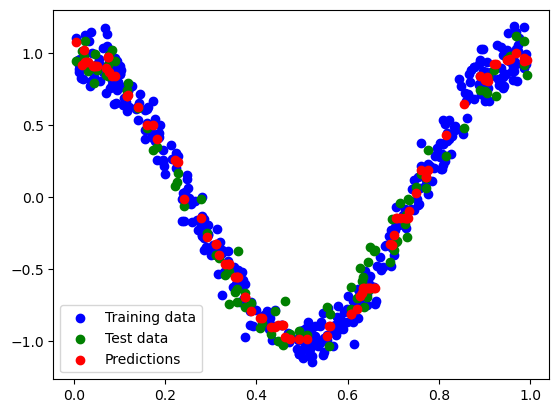

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Axes: >

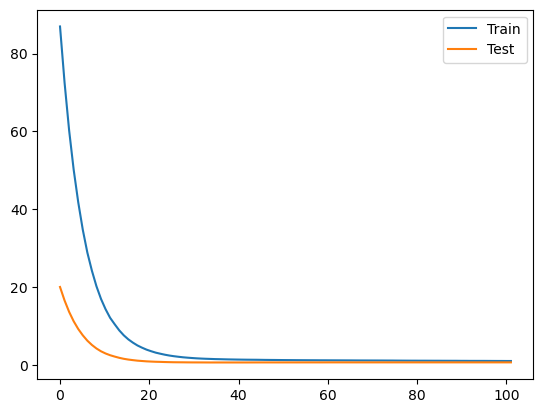

In [14]:
    
np.random.seed(42)
X = np.random.rand(500, 1)  
y = np.cos(2 * np.pi * X).ravel() + np.random.randn(500) * 0.1  # noisy sine wave

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor()
n_estimators=100
gbr.fit(X_train, y_train,n_estimators=n_estimators,max_depth=3, lr=0.1)

predictions,L,L_test = gbr.predict(X_test,y_test)

plt.scatter(X_train, y_train, label="Training data", color="blue")
plt.scatter(X_test, y_test, label="Test data", color="green")
plt.scatter(X_test, predictions, label="Predictions", color="red")
plt.legend()
plt.show()     

#we are going to show loss-decays for train set and test set
sns.lineplot(x=np.linspace(0,n_estimators+1,n_estimators),y=L, label='Train') 

sns.lineplot(x=np.linspace(0,n_estimators+1,n_estimators),y=L_test, label='Test')

    

## Classification
In this test I decided to make a funny classification. I decided to use a public dataset present on Kaggle: pokemon! Let us therefore take this public dataset consisting of Pokemon and analyse its columns. In this dataset we will classify which pokemon is legendary and which not. 

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif
# Optional: Plot the results
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

#let's import libraries!

In [7]:

Data=pd.read_csv("pokemon.csv")

X = Data.drop(columns=['is_legendary']).select_dtypes(include=['number'])#we select numerical feature
y = Data['is_legendary'] #we select the target feature
feature_names = X.columns

print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        801 non-null    float64
 1   against_dark       801 non-null    float64
 2   against_dragon     801 non-null    float64
 3   against_electric   801 non-null    float64
 4   against_fairy      801 non-null    float64
 5   against_fight      801 non-null    float64
 6   against_fire       801 non-null    float64
 7   against_flying     801 non-null    float64
 8   against_ghost      801 non-null    float64
 9   against_grass      801 non-null    float64
 10  against_ground     801 non-null    float64
 11  against_ice        801 non-null    float64
 12  against_normal     801 non-null    float64
 13  against_poison     801 non-null    float64
 14  against_psychic    801 non-null    float64
 15  against_rock       801 non-null    float64
 16  against_steel      801 non

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,experience_growth,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1059860,0.7,45,88.1,1,65,65,45,6.9,1
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1059860,1.0,60,88.1,2,80,80,60,13.0,1
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1059860,2.0,80,88.1,3,122,120,80,100.0,1
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,1059860,0.6,39,88.1,4,60,50,65,8.5,1
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,1059860,1.1,58,88.1,5,80,65,80,19.0,1


In [8]:
X=X.interpolate(method='linear')# here we fill nan with an interpolation method
scaler = MinMaxScaler(feature_range=(-1, 1)) #we select minscaler to normalize data
X_scaled = scaler.fit_transform(X) #we normalize data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=45) #let's create: train and test
#set

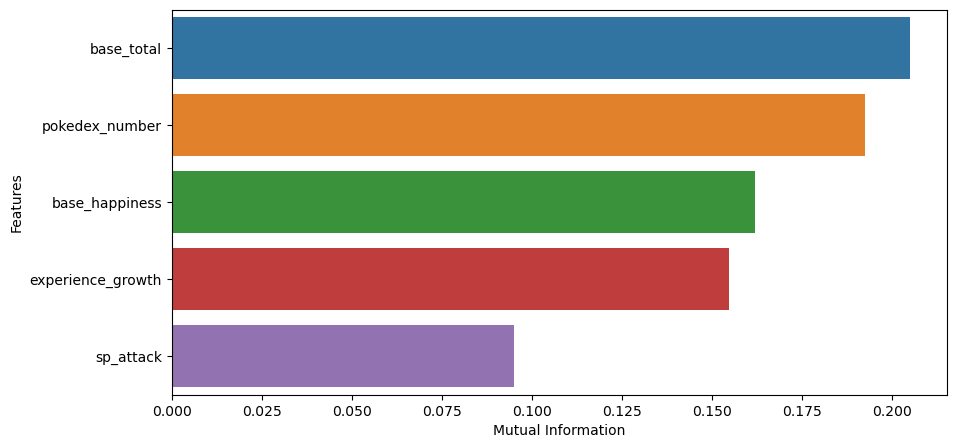

In [9]:
#we are going to select features using mutual info classification
mi=mutual_info_classif(X_train, y_train, discrete_features='auto',random_state=45)

sorted_indices = np.argsort(mi)[::-1]

Feature_selected=6 #we select just 6-1 (then 5) features

sorted_indices=sorted_indices[:Feature_selected]

X_train=X_train[:,sorted_indices]

X_test=X_test[:,sorted_indices]

sorted_pairs = sorted(zip(mi, feature_names),reverse=True)
x_sorted, y_sorted = zip(*sorted_pairs)

fig, axs = plt.subplots(1,figsize=(10, 5))

sns.barplot(x=np.array(x_sorted)[1:Feature_selected], y=np.array(y_sorted)[1:Feature_selected])

plt.xlabel('Mutual Information')

plt.ylabel('Features')

plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0.5, 1.0, 'Confusion Matrix')

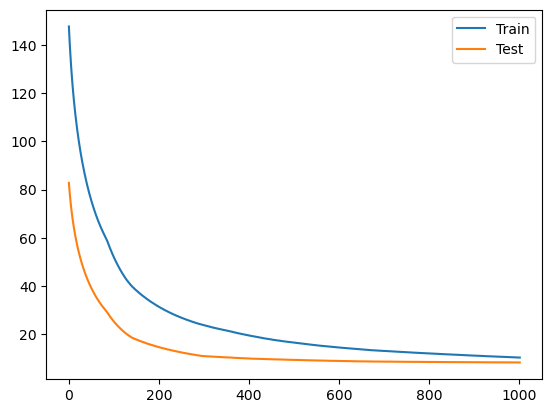

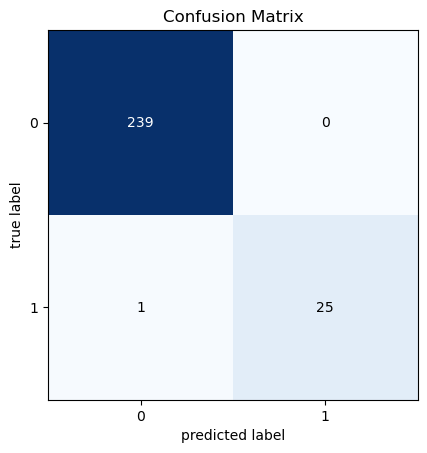

In [10]:
# let's use gbm to classify poemon between legendary and not :)


class GradientBoostingClassifier:
   #let's define Sigmoid function
   def sigmoid_function(self, x): 
        if x >= 0:
            z = np.exp(-x)
            
            return 1/(1+z)
        
        else:
    # if x is less than zero then z will be small, denom can't be
    # zero because it's 1+z.
            z = np.exp(x)
            
            return z / (1 + z)  
   def sigmoid(self, x):
        return np.array([self.sigmoid_function(value) for value in x])
        
   #we define loss (cross-entropy)    
   def loss(self,pred,y): 
        predict_1 = y * np.log(pred)
        predict_0 = (1 - y) * np.log(1-pred)    
        return -np.sum(predict_1 + predict_0)
   
   #we define residuals
   def pseudoresiduals(self,pred,y):
        res=(y-pred)
        return res
    
   def fit(self,X,y,n_estimators, max_depth, lr):
          
        logodds=np.log(len(y[y==1])/len(y[y==0])) #logodds

        logoddsprediction=logodds*np.ones(len(y))
        
        logodds_start=logodds
         
        prob=self.sigmoid_function(logodds)*np.ones(len(y))
                
        initial_prediction=prob
                                
        trees=[]
        
        Loss=np.random.rand(n_estimators)
              
        res=self.pseudoresiduals(prob,y)
                
        #let's "modify" regression tree with formula before.
        for k in range(0,n_estimators):
                        
            tree=DecisionTreeRegressor(max_depth=max_depth)
            
            tree.fit(X,res)
            
            ids = tree.apply(X)  
            
            # loop through the terminal nodes 
            for j in np.unique(ids):
                
                            
              fltr = ids==j

              num = np.sum(res[fltr])
              den = np.sum(prob[fltr]*(1-prob[fltr]))
                            
              gamma = num / den
                 
              logoddsprediction[fltr] += lr * gamma
              
              tree.tree_.value[j] = gamma

            prob=self.sigmoid(logoddsprediction)
                        
            res=self.pseudoresiduals(prob,y)

            L=self.loss(prob,y)
                                    
            trees.append(tree)
            
            Loss[k]=L
            
        self.trees=trees
        
        self.Loss=Loss
        
        self.lr=lr
        
        self.initial_prediction=initial_prediction
        
        self.gamma=gamma
        
        self.logodds_start=logodds_start

        
   def predict(self, X,y=None):
                
        L_test=[]
        
        logoddspred=self.logodds_start
        
        for tree in self.trees:
            
            logoddspred+= self.lr * tree.predict(X)

            
            predictions=self.sigmoid(logoddspred)

            try:
                L_test1=self.loss(predictions,y)
                
                L_test.append(L_test1)
                
            except:
                pass
            
        return [1 if i > 0.5 else 0 for i in predictions],self.Loss, L_test
    


gbm = GradientBoostingClassifier()

n_estimators=1000
gbm.fit(X_train, y_train,n_estimators=n_estimators,max_depth=1, lr=0.01)

predictions,L,L_test = gbm.predict(X_test,y_test)

sns.lineplot(x=np.linspace(0,n_estimators+1,n_estimators),y=L, label='Train')

sns.lineplot(x=np.linspace(0,n_estimators+1,n_estimators),y=L_test, label='Test')

conf_matrix = confusion_matrix(y_test, predictions)

plot_confusion_matrix(conf_matrix, show_absolute=True, show_normed=False)

plt.title('Confusion Matrix')


I would say it was a very good result! We showed how the use of this algorithm is also optimal for classification :) .